In [1]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [133]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D
from keras.layers import Conv2D,Conv3D, Lambda
from keras.backend import transpose
from keras.optimizers import Adam
from keras import regularizers

(10, 10, 4000)


<Figure size 432x288 with 0 Axes>

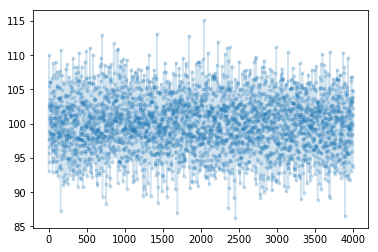

<Figure size 432x288 with 0 Axes>

In [3]:
i = randint(0,900)
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
Ft = load(datadir+"d"+str(i).zfill(4)+".npy")

Ftsh = Ft.shape
width,height,T = Ftsh  
print(Ftsh)
t = arange(Ftsh[-1])
figure()
plot(t,sum(sum(Ft,axis=0),axis=0),'.-',alpha=0.2)
figure()

In [4]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [5]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [6]:
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2

def ftaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[1])//2)
    fftim  = fftshift(fft2(img))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim)))
    return(imgn)

def ftvaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[0])//2)
    fftim  = fftshift(fft2(img,axes=(0,1)),axes=(0,1))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim,axes=(0,1)),axes=(0,1)))
    imgn = imgn[:,:,sh2[0]:-sh2[0]]
    return(imgn)

In [221]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 500
magn=2

X = []
Y = []
for i in range(800):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o2_"+str(i).zfill(4)+".npy") 
    xt = xt/mean(xt.flatten())
    xt = ftvaugment(xt,magn)
    ymax = max(1,max(yt.flatten()))
    yt = yt
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(10):
        start,end = get_random_time_segment(nframes,T)
        X.append(xt[:,:,start:end])
        #Y.append(concatenate((yt[start:end],par[-1:])))
        ytr = 0.05*ymax*randn(magn*width,magn*height)
        Y.append((yt+ytr)/ymax)
    if i %200 == 0:
        print("Iteracion #",i)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(800,900):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o2_"+str(i).zfill(4)+".npy")
    xt = xt/mean(xt.flatten())
    xt = ftvaugment(xt,magn)
    
    ymax = max(1,max(yt.flatten()))
    yt = yt
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(5):
        start,end = get_random_time_segment(nframes,T)
        Xdev.append(xt[:,:,start:end])
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        ytr = 0.05*ymax*randn(magn*width,magn*height)
        Ydev.append((yt+ytr)/ymax)
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

Iteracion # 0
Iteracion # 200
Iteracion # 400
Iteracion # 600
(8000, 20, 20, 500) (8000, 20, 20)
(500, 20, 20, 500) (500, 20, 20)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

In [222]:
X.shape

(8000, 20, 20, 500)

5119


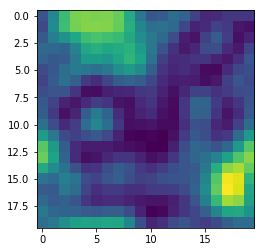

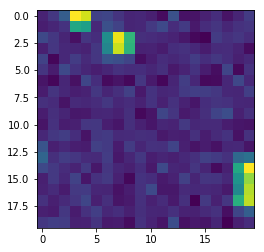

In [223]:
colors = array(['C0','C1'])
t = arange(1000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])
imshow(sum(X[i,:,:],axis=-1))
figure()
imshow(Y[i,:])
print(i)

In [224]:
print(X.shape)
print(Y.shape)
print(Xdev.shape)
print(Ydev.shape)
width

(8000, 20, 20, 500)
(8000, 20, 20)
(500, 20, 20, 500)
(500, 20, 20)


10

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [225]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],Xdev.shape[3],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],Ydev.shape[2],1,1))

In [226]:
print(X.shape,Y.shape)

(8000, 20, 20, 500, 1) (8000, 20, 20, 1, 1)


In [366]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    magn = 2
    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input
    
    Xa = MaxPooling3D((1,1,40),strides=(1,1,5),padding="same")(X)
    Xb = AveragePooling3D((1,1,40),strides=(1,1,5),padding="same")(X)
    
    X = Concatenate()([Xa,Xb])
    
    X = BatchNormalization()(X)   

    X = Dropout(0.3)(X)
    
    X = Conv3D(40,(4,4,4),strides=(1,1,2),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)
    X = AveragePooling3D((1,1,20),strides=(1,1,3),padding="same")(X)
    X = BatchNormalization()(X)   
   
    X = Dropout(0.3)(X)
    X = Conv3D(80,(1,1,13),strides=(1,1,17),padding="valid")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X) 

    
    #X = Dropout(0.3)(X)
    #X = MaxPooling3D((1,1,10),strides=(1,1,1),padding="same")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 

    #X = Dropout(0.3)(X)
    #X = Conv3D(80,(1,1,10),strides=(1,1,2),padding="valid")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 
    X = Dropout(0.3)(X)
    X = Dense(20,activation="relu")(X)
    X = BatchNormalization()(X) 

    X = Dropout(0.3)(X)
    X = Dense(5,activation="relu")(X)
    X = BatchNormalization()(X) 
    
    
    X = Dropout(0.3)(X)
    X = Dense(1,activation="relu",kernel_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l2(0.001))(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [367]:
model = model(input_shape = (magn*width,magn*height,nframes,1))

In [368]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 20, 20, 500,  0                                            
__________________________________________________________________________________________________
max_pooling3d_26 (MaxPooling3D) (None, 20, 20, 100,  0           input_33[0][0]                   
__________________________________________________________________________________________________
average_pooling3d_29 (AveragePo (None, 20, 20, 100,  0           input_33[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 20, 20, 100,  0           max_pooling3d_26[0][0]           
                                                                 average_pooling3d_29[0][0]       
__________

### Fit the model!

In [369]:
from keras.optimizers import SGD

In [370]:
import keras.backend as K
def brutal_log(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.flatten(K.log(y_true+1e-8))
    ly2 = K.flatten(K.log(y_pred+1e-8))

    lyf = K.cast(K.flatten(ly> -100.0),dtype='float32')
    lyf2 = K.cast(K.flatten(ly2> -100.0),dtype='float32')
    lyf = lyf2*lyf
    out = K.mean((ly*lyf-ly2*lyf)**2)+200.0*K.mean(lyf2)
    return out

#Mendel ...
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return out

def MOCl(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = 1.0-ly/K.sqrt(ly2*ly3)
    return out
#Pearson Correlation
def PCC(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return out

def PCCl(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out




model_log = brutal_log_m

In [371]:
opt = Adam(lr=0.001, beta_1=0.90, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss=PCCl, optimizer=opt, metrics=[MOC])
#model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=["accuracy"])
#model.compile(loss=brutal_log, optimizer=opt, metrics=["accuracy"])


In [374]:
#Wsave = model.get_weights()
model.set_weights(Wsave)

In [375]:
history2 = model.fit(X, Y, batch_size = 100, epochs = 1000)

Epoch 1/1000
8000/8000 [==============================] - 37s 5ms/step - loss: 9.2904 - MOC: 0.1268
Epoch 2/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 1.8814 - MOC: 0.1265
Epoch 3/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 1.3822 - MOC: 0.1104
Epoch 4/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 1.2414 - MOC: 0.1008
Epoch 5/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 1.1484 - MOC: 0.0985
Epoch 6/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 1.1060 - MOC: 0.1017
Epoch 7/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 1.0726 - MOC: 0.1109
Epoch 8/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 1.0482 - MOC: 0.1200
Epoch 9/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 1.0343 - MOC: 0.1377
Epoch 10/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.9924 - MOC: 0.1683

8000/8000 [==============================] - 31s 4ms/step - loss: 0.5038 - MOC: 0.5351
Epoch 83/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.5034 - MOC: 0.5324
Epoch 84/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.4897 - MOC: 0.5457
Epoch 85/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.5017 - MOC: 0.5355
Epoch 86/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4963 - MOC: 0.5381
Epoch 87/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4969 - MOC: 0.5390
Epoch 88/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4897 - MOC: 0.5453
Epoch 89/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4996 - MOC: 0.5370
Epoch 90/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.5039 - MOC: 0.5339
Epoch 91/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.4868 - MOC: 0.5484
Epoc

8000/8000 [==============================] - 31s 4ms/step - loss: 0.4446 - MOC: 0.5854
Epoch 163/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.4444 - MOC: 0.5858
Epoch 164/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.4412 - MOC: 0.5883
Epoch 165/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4399 - MOC: 0.5897
Epoch 166/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4397 - MOC: 0.5893
Epoch 167/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4411 - MOC: 0.5885
Epoch 168/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4374 - MOC: 0.5914
Epoch 169/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4389 - MOC: 0.5901
Epoch 170/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.4363 - MOC: 0.5924
Epoch 171/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.4339 - MOC: 0.

8000/8000 [==============================] - 33s 4ms/step - loss: 0.3855 - MOC: 0.6365
Epoch 243/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3836 - MOC: 0.6382
Epoch 244/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3869 - MOC: 0.6351
Epoch 245/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3845 - MOC: 0.6373
Epoch 246/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3855 - MOC: 0.6363
Epoch 247/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3827 - MOC: 0.6390
Epoch 248/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3833 - MOC: 0.6382
Epoch 249/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3802 - MOC: 0.6414
Epoch 250/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3817 - MOC: 0.6399
Epoch 251/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3817 - MOC: 0.

8000/8000 [==============================] - 32s 4ms/step - loss: 0.3558 - MOC: 0.6629
Epoch 323/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3541 - MOC: 0.6644
Epoch 324/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3547 - MOC: 0.6638
Epoch 325/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3538 - MOC: 0.6647
Epoch 326/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3526 - MOC: 0.6659
Epoch 327/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3534 - MOC: 0.6650
Epoch 328/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3533 - MOC: 0.6651
Epoch 329/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3526 - MOC: 0.6658
Epoch 330/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3523 - MOC: 0.6659
Epoch 331/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3521 - MOC: 0.

8000/8000 [==============================] - 32s 4ms/step - loss: 0.3432 - MOC: 0.6740
Epoch 403/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3440 - MOC: 0.6731
Epoch 404/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3434 - MOC: 0.6737
Epoch 405/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3430 - MOC: 0.6741
Epoch 406/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3432 - MOC: 0.6740
Epoch 407/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3430 - MOC: 0.6741
Epoch 408/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3429 - MOC: 0.6742
Epoch 409/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3424 - MOC: 0.6747
Epoch 410/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3433 - MOC: 0.6739
Epoch 411/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3418 - MOC: 0.

8000/8000 [==============================] - 31s 4ms/step - loss: 0.3386 - MOC: 0.6779
Epoch 483/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3376 - MOC: 0.6789
Epoch 484/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3389 - MOC: 0.6778
Epoch 485/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3374 - MOC: 0.6792
Epoch 486/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3379 - MOC: 0.6787
Epoch 487/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3379 - MOC: 0.6787
Epoch 488/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3380 - MOC: 0.6786
Epoch 489/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3380 - MOC: 0.6786
Epoch 490/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3376 - MOC: 0.6789
Epoch 491/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3381 - MOC: 0.

8000/8000 [==============================] - 32s 4ms/step - loss: 0.3335 - MOC: 0.6828
Epoch 563/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3325 - MOC: 0.6837
Epoch 564/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3326 - MOC: 0.6836
Epoch 565/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3331 - MOC: 0.6832
Epoch 566/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3328 - MOC: 0.6834
Epoch 567/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3324 - MOC: 0.6838
Epoch 568/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3326 - MOC: 0.6837
Epoch 569/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3328 - MOC: 0.6834
Epoch 570/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3323 - MOC: 0.6839
Epoch 571/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3326 - MOC: 0.

8000/8000 [==============================] - 33s 4ms/step - loss: 0.3279 - MOC: 0.6880
Epoch 643/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3283 - MOC: 0.6876
Epoch 644/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3287 - MOC: 0.6873
Epoch 645/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3268 - MOC: 0.6891
Epoch 646/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3288 - MOC: 0.6871
Epoch 647/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3279 - MOC: 0.6880
Epoch 648/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3279 - MOC: 0.6880
Epoch 649/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3273 - MOC: 0.6886
Epoch 650/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3273 - MOC: 0.6885
Epoch 651/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3270 - MOC: 0.

8000/8000 [==============================] - 31s 4ms/step - loss: 0.3238 - MOC: 0.6919
Epoch 723/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3243 - MOC: 0.6914
Epoch 724/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3240 - MOC: 0.6916
Epoch 725/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3247 - MOC: 0.6910
Epoch 726/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3241 - MOC: 0.6915
Epoch 727/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3238 - MOC: 0.6918
Epoch 728/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3240 - MOC: 0.6916
Epoch 729/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3239 - MOC: 0.6917
Epoch 730/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3246 - MOC: 0.6911
Epoch 731/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3238 - MOC: 0.

8000/8000 [==============================] - 31s 4ms/step - loss: 0.3224 - MOC: 0.6931
Epoch 803/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3230 - MOC: 0.6926
Epoch 804/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3226 - MOC: 0.6929
Epoch 805/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3234 - MOC: 0.6922
Epoch 806/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3220 - MOC: 0.6934
Epoch 807/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3234 - MOC: 0.6922
Epoch 808/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3223 - MOC: 0.6932
Epoch 809/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3230 - MOC: 0.6925
Epoch 810/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3227 - MOC: 0.6929
Epoch 811/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3220 - MOC: 0.

8000/8000 [==============================] - 32s 4ms/step - loss: 0.3217 - MOC: 0.6938
Epoch 883/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3210 - MOC: 0.6944
Epoch 884/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3211 - MOC: 0.6943
Epoch 885/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3216 - MOC: 0.6938
Epoch 886/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3217 - MOC: 0.6938
Epoch 887/1000
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3213 - MOC: 0.6941
Epoch 888/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3211 - MOC: 0.6943
Epoch 889/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3209 - MOC: 0.6945
Epoch 890/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3213 - MOC: 0.6941
Epoch 891/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3219 - MOC: 0.

8000/8000 [==============================] - 32s 4ms/step - loss: 0.3210 - MOC: 0.6944
Epoch 963/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3205 - MOC: 0.6949
Epoch 964/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3204 - MOC: 0.6950
Epoch 965/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3215 - MOC: 0.6940
Epoch 966/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3208 - MOC: 0.6946
Epoch 967/1000
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3206 - MOC: 0.6948
Epoch 968/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3205 - MOC: 0.6948
Epoch 969/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3205 - MOC: 0.6948
Epoch 970/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3203 - MOC: 0.6951
Epoch 971/1000
8000/8000 [==============================] - 32s 4ms/step - loss: 0.3207 - MOC: 0.

In [401]:
#Wsave_trained1 = model.get_weights()
Wsave_trained2MSE = model.get_weights()
#Wsave_trained4MSLE = model.get_weights()
#Wsave_trained4BLE = model.get_weights()

#Wsave_trained3 = model.get_weights()

Text(0.5,0,'epoch')

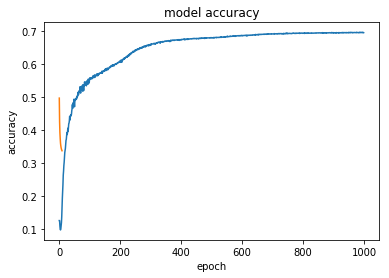

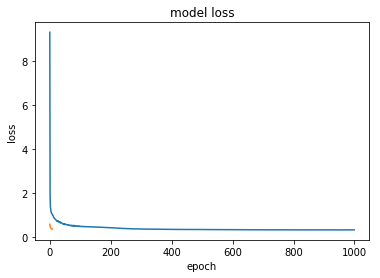

In [379]:
figure()
#print(history3.history.keys())
#plot(history.history['acc'])
#plot(history3.history['acc'])
plot(history2.history['MOC'])
plot(history1.history['MOC'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
#plot(history3.history['loss'])
plot(history2.history['loss'])
plot(history1.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


In [382]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

500/500 [==============================] - 3s 7ms/step
Dev set accuracy =  0.705632709980011


In [335]:
#%matplotlib notebook

(1, 20, 20, 500, 1)
(1, 20, 20, 1, 1)


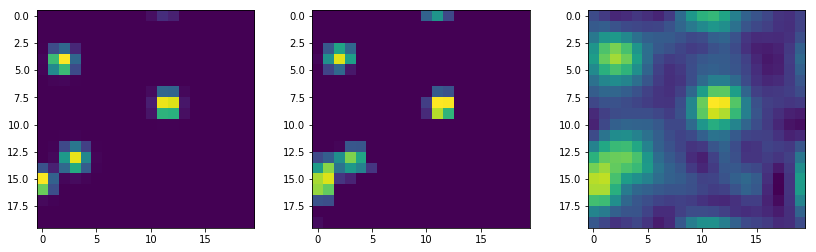

In [411]:
figure(figsize=(14,4))
i = 800+randint(100)
a = load(datadir+"d"+str(i).zfill(4)+".npy");
b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
subplot(1, 3, 1)
imshow(b)

start = randint(T-500)
end = start+500
xt = a[:,:,start:end]
xt = xt/mean(xt.flatten())
xt = ftvaugment(xt,magn)
xt = reshape(xt,(1,magn*width,magn*height,500,1))
print(xt.shape)
y = model.predict(xt)
print(y.shape)
#print(squeeze(y).shape)
subplot(1, 3, 2)
imshow(squeeze(y))
subplot(1, 3, 3)
imshow(sum(xt[0,:,:,:,0],axis=-1))

In [309]:
maxb = []
for i in range(900):
    b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
    maxb.append(max(b.flatten()))

In [184]:
sum(array(maxb)<1e-3)/900


0.11333333333333333

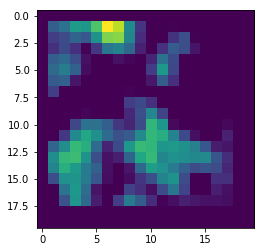

In [50]:
imshow(squeeze(y),vmin= 1.21)

In [413]:
model.save("deepsofi_x2_20180920.h5")
